In [1]:
import sys, pickle
import pandas as pd
import numpy as np
from sklearn import preprocessing
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
import lightgbm as lgb
from sklearn.metrics import mean_squared_error
pd.set_option('display.max_columns', None)

import re
import nltk 
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from scipy.stats import norm, skew #for some statistics
%matplotlib inline

## I. Load related data

In [2]:
listings = pd.read_csv("data/listings.csv.gz")
reviews = pd.read_csv("data/reviews.csv.gz")
# listings = pd.read_csv("http://data.insideairbnb.com/united-states/ca/san-diego/2020-12-23/data/listings.csv.gz")
# reviews = pd.read_csv("http://data.insideairbnb.com/united-states/ca/san-diego/2020-12-23/data/reviews.csv.gz")

## II. Data inspections
### II.1 Data value inspections 

In [3]:
long_content_cols = ["description", "neighborhood_overview", "picture_url", 
                     "host_url", "host_about", "host_thumbnail_url", "host_picture_url"]
listings.drop(long_content_cols, axis=1).head()

,id,listing_url,scrape_id,last_scraped,name,host_id,host_name,host_since,host_location,host_response_time,host_response_rate,host_acceptance_rate,host_is_superhost,host_neighbourhood,host_listings_count,host_total_listings_count,host_verifications,host_has_profile_pic,host_identity_verified,neighbourhood,neighbourhood_cleansed,neighbourhood_group_cleansed,latitude,longitude,property_type,room_type,accommodates,bathrooms,bathrooms_text,bedrooms,beds,amenities,price,minimum_nights,maximum_nights,minimum_minimum_nights,maximum_minimum_nights,minimum_maximum_nights,maximum_maximum_nights,minimum_nights_avg_ntm,maximum_nights_avg_ntm,calendar_updated,has_availability,availability_30,availability_60,availability_90,availability_365,calendar_last_scraped,number_of_reviews,number_of_reviews_ltm,number_of_reviews_l30d,first_review,last_review,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,license,instant_bookable,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month
0,5570,https://www.airbnb.com/rooms/5570,20201223070513,2020-12-23,Ocean front condo on the sand,8435,Jef Karchin,2009-02-23,"San Diego, California, United States",within a few hours,100%,100%,f,Mission Beach,3.0,3.0,"['email', 'phone', 'kba']",t,t,"San Diego, California, United States",Mission Bay,NaN,32.78430,-117.25258,Entire condominium,Entire home/apt,6,NaN,1 bath,2.0,4.0,"[""Iron"", ""Elevator"", ""Stove"", ""Microwave"", ""Di...","$2,050.00",3,365,3.0,3.0,365.0,365.0,3.0,365.0,NaN,t,6,21,44,207,2020-12-23,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,f,3,3,0,0,NaN
1,29967,https://www.airbnb.com/rooms/29967,20201223070513,2020-12-23,"Great home, 10 min walk to Beach",129123,Michael,2010-05-21,"San Diego, California, United States",within an hour,100%,50%,t,Pacific Beach,6.0,6.0,"['email', 'phone', 'reviews', 'kba', 'work_ema...",t,t,NaN,Pacific Beach,NaN,32.80724,-117.25630,Entire bungalow,Entire home/apt,8,NaN,2 baths,2.0,3.0,"[""Iron"", ""Hot water"", ""Heating"", ""Kitchen"", ""W...",$261.00,4,365,4.0,4.0,365.0,365.0,4.0,365.0,NaN,t,6,6,6,213,2020-12-23,62,2,1,2010-07-09,2020-11-29,98.0,10.0,10.0,10.0,10.0,10.0,10.0,NaN,f,5,5,0,0,0.49
2,38245,https://www.airbnb.com/rooms/38245,20201223070513,2020-12-23,Point Loma: Den downstairs,164137,Melinda,2010-07-12,"San Diego, California, United States",within a day,100%,86%,f,Loma Portal,3.0,3.0,"['email', 'phone', 'reviews', 'kba']",t,t,"San Diego, California, United States",Roseville,NaN,32.74202,-117.21870,Private room in house,Private room,1,NaN,1 shared bath,1.0,1.0,"[""Iron"", ""Hot water"", ""Dishes and silverware"",...",$74.00,1,21,1.0,1.0,21.0,21.0,1.0,21.0,NaN,t,24,54,84,359,2020-12-23,143,0,0,2010-09-09,2019-10-20,86.0,9.0,9.0,10.0,10.0,9.0,9.0,NaN,f,3,0,3,0,1.14
3,54001,https://www.airbnb.com/rooms/54001,20201223070513,2020-12-23,"La Jolla 2 Bdr Cottage: 1 Qn; 2Twns, Blks 2 Ocn",252692,Marsha,2010-10-04,"San Diego, California, United States",within an hour,100%,75%,t,La Jolla,5.0,5.0,"['email', 'phone', 'reviews', 'kba']",t,t,"La Jolla, California, United States",La Jolla,NaN,32.81301,-117.26856,Entire guesthouse,Entire home/apt,3,NaN,1 bath,2.0,5.0,"[""Luggage dropoff allowed"", ""Single level home...",$110.00,3,365,3.0,30.0,18.0,1125.0,23.0,1079.9,NaN,t,0,0,18,99,2020-12-23,244,30,5,2011-01-04,2020-12-22,99.0,10.0,10.0,10.0,10.0,10.0,10.0,NaN,f,2,1,1,0,2.01
4,62274,https://www.airbnb.com/rooms/62274,20201223070513,2020-12-23,"charming, colorful, close to beach",302986,Isabel,2010-11-28,"San Diego, California, United States",within an hour,92%,95%,t,Pacific Beach,2.0,2.0,"['email', 'phone', 'reviews', 'kba']",t,t,"San Diego, California, United States",Pacific Beach,NaN,32.80734,-117.24243,Entire guesthouse,Entire home/apt,2,NaN,1 bath,1.0,1.0,"[""Luggage dropoff allowed"",

#### Data field descriptions
room_id: A unique number identifying an Airbnb listing.

host_id: A unique number identifying an Airbnb host.

neighborhood: A subregion of the city or search area for which the survey is carried out. For some cities there is no neighbourhood information.

room_type: One of “Entire home/apt”, “Private room”, or “Shared room”.

host_response_rate: The rate at which the particular host responds to the customers.

price: The price (in $US) for a night stay. In early surveys, there may be some values that were recorded by month.

accomodates: The number of guests a listing can accommodate.

bathrooms: The number of bathrooms a listing offers.

bedrooms: The number of bedrooms a listing offers.

beds: The number of beds a listing offers.

minimum_nights: The minimum stay for a visit, as posted by the host.

maximum nights: The maximum stay for a visit, as posted by the host.

overall_satisfaction: The average rating (out of five) that the listing has received from those visitors who left a review.

number_of_reviews: The number of reviews that a listing has received. Airbnb has said that 70% of visits end up with a review, so the number of reviews can be used to estimate the number of visits. Note that such an estimate will not be reliable for an individual listing (especially as reviews occasionally vanish from the site), but over a city as a whole it should be a useful metric of traffic.

reviews_per_month: The number of reviews that a listing has received per month.

host_listings_count: The number of listingsfora particular host.

availability_365: The number of days for which a particular host is available in a year.

### II.2 Price heatmap

## III. Data pre-processing

### III.1 get rid of columns with no information

In [4]:
exclude_list = [] 
for col in listings.columns:
    value_cnts = len(listings[col].unique())
    if value_cnts < 2:
        exclude_list.append(col)

# too many null values 
is_null_cnt = listings.isnull().sum()
exclude_list += list(is_null_cnt[is_null_cnt > listings.shape[0]/4].index)
exclude_list = list(set(exclude_list))
print(exclude_list)


# no for analysis
exclude_list += ["scrape_id", "host_id"]
exclude_list += ["latitude", "longitude"]


# get rid of columns
listings = listings.drop(exclude_list ,axis=1)

['neighborhood_overview', 'neighbourhood_group_cleansed', 'bathrooms', 'host_about', 'neighbourhood', 'license', 'calendar_updated', 'scrape_id']


### III.2 seperate numeric and non-numeric data and process with different methods

In [5]:
df_numeric = listings.select_dtypes(exclude=['object'])

# via data inspections
useful_cat_varibles = ["neighbourhood_cleansed", "host_identity_verified", "host_neighbourhood"]
useful_cat_varibles += ["property_type", "room_type"]
useful_cat_varibles += ["host_response_time"]
df_cat = listings[useful_cat_varibles]

description_cols = ["description", "host_about"]
ser_amenities = listings.amenities

# format parsing
Y = listings.price.str.replace("$","").str.replace(",","").astype(float)


# encode category variable into numeric one
le_dict = {}
categorical_feature = []
for col in df_cat.columns:
    le = preprocessing.LabelEncoder()
    le.fit(df_cat[col])
    le_dict[col] = le
    encoded_fts = le.transform(df_cat[col])
    df_cat[col] = encoded_fts
    categorical_feature.append(col)

df_all = pd.concat([df_numeric, df_cat], axis=1)
df_all["n_amenities"] = ser_amenities.apply(lambda x: len(eval(x)))

/Users/lucaslee/anaconda3/envs/lucas_test/lib/python3.6/site-packages/ipykernel_launcher.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


### III.3 missing data imputation

In [6]:
# show all varibles with missing data
varibles_na_cnt = df_all.isnull().sum()
print(varibles_na_cnt[varibles_na_cnt > 0])

host_listings_count               3
host_total_listings_count         3
bedrooms                        997
beds                             50
minimum_minimum_nights            1
maximum_minimum_nights            1
minimum_maximum_nights            1
maximum_maximum_nights            1
minimum_nights_avg_ntm            1
maximum_nights_avg_ntm            1
review_scores_rating           1482
review_scores_accuracy         1525
review_scores_cleanliness      1524
review_scores_checkin          1527
review_scores_communication    1525
review_scores_location         1527
review_scores_value            1527
reviews_per_month              1441
dtype: int64


In [7]:
imputer_dict = {}
for col in varibles_na_cnt[varibles_na_cnt > 0].index:
    if "review" in col:
        value_to_fill = 0
    else:
        most_freq = df_all[col].value_counts().index[0]
        value_to_fill = most_freq    
    df_all[col].fillna(value_to_fill, inplace=True)
    imputer_dict[col] = value_to_fill

/Users/lucaslee/anaconda3/envs/lucas_test/lib/python3.6/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)



 mu = 295.78 and sigma = 960.68



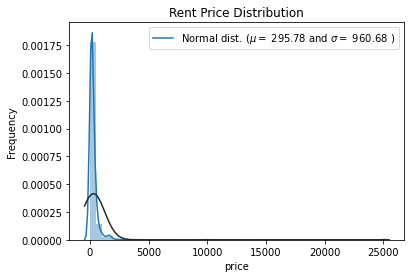

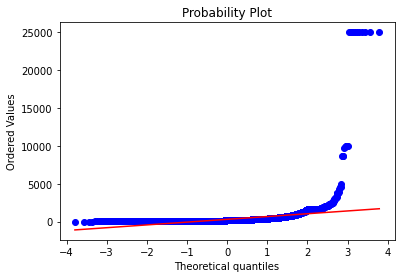

In [8]:
sns.distplot(Y , fit=norm);

# Get the fitted parameters used by the function
(mu, sigma) = norm.fit(Y)
print( '\n mu = {:.2f} and sigma = {:.2f}\n'.format(mu, sigma))

#Now plot the distribution
plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)],
            loc='best')
plt.ylabel('Frequency')
plt.title('Rent Price Distribution')

#Get also the QQ-plot
fig = plt.figure()
res = stats.probplot(Y, plot=plt)
plt.show()

- there are impossible data points exist, need to exclude them
- the price should apply log transform for better performance 

In [9]:
idx_reasonable_price = (Y > 0) & (Y < 6000)
Y = Y[idx_reasonable_price]
df_all = df_all[idx_reasonable_price]
Y = np.log1p(Y)

/Users/lucaslee/anaconda3/envs/lucas_test/lib/python3.6/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)



 mu = 5.13 and sigma = 0.85



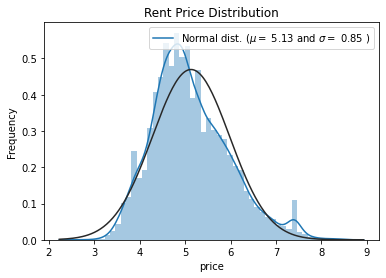

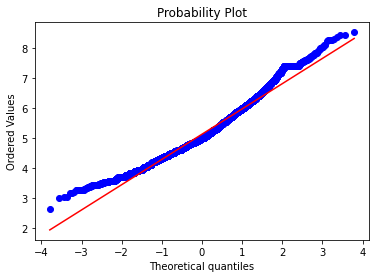

In [10]:
sns.distplot(Y , fit=norm)
# Get the fitted parameters used by the function
(mu, sigma) = norm.fit(Y)
print( '\n mu = {:.2f} and sigma = {:.2f}\n'.format(mu, sigma))

#Now plot the distribution
plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)],
            loc='best')
plt.ylabel('Frequency')
plt.title('Rent Price Distribution')

#Get also the QQ-plot
fig = plt.figure()
res = stats.probplot(Y, plot=plt)
plt.show()

## IV. Split training and testing datasets

In [11]:
X = df_all.drop(["id"],axis=1)
X_train, X_test, y_train_log, y_test_log = train_test_split(X, Y, test_size=0.33, random_state=9527)

In [12]:
X_train.head()

,host_listings_count,host_total_listings_count,accommodates,bedrooms,beds,minimum_nights,maximum_nights,minimum_minimum_nights,maximum_minimum_nights,minimum_maximum_nights,maximum_maximum_nights,minimum_nights_avg_ntm,maximum_nights_avg_ntm,availability_30,availability_60,availability_90,availability_365,number_of_reviews,number_of_reviews_ltm,number_of_reviews_l30d,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month,neighbourhood_cleansed,host_identity_verified,host_neighbourhood,property_type,room_type,host_response_time,n_amenities
369,5.0,5.0,2,1.0,2.0,1,1125,1.0,1.0,1125.0,1125.0,1.0,1125.0,3,7,11,71,11,0,0,98.0,10.0,10.0,10.0,10.0,10.0,10.0,1,0,1,0,0.15,47,1,159,36,2,3,7
6326,2.0,2.0,12,5.0,5.0,2,1125,2.0,3.0,1125.0,1125.0,2.0,1125.0,10,10,10,276,16,14,0,100.0,10.0,10.0,10.0,10.0,10.0,10.0,2,1,1,0,1.19,76,1,180,14,0,3,45
5619,5.0,5.0,4,1.0,2.0,1,1125,1.0,2.0,1125.0,1125.0,1.3,1125.0,15,43,72,164,87,67,4,97.0,10.0,10.0,10.0,10.0,10.0,9.0,4,4,0,0,5.00,56,1,147,14,0,3,37
4743,36.0,36.0,12,4.0,6.0,2,28,2.0,2.0,1125.0,1125.0,2.0,1125.0,27,57,87,276,3,1,0,93.0,10.0,10.0,10.0,10.0,10.0,10.0,35,35,0,0,0.12,67,1,140,6,0,3,37
7950,0.0,0.0,2,1.0,1.0,2,1125,2.0,2.0,1125.0,1125.0,2.0,1125.0,0,28,58,333,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,0,1,0,0.00,96,1,234,36,2,4,13


## V. Model traing and Evaluation

In [13]:
# create dataset for lightgbm
lgb_train = lgb.Dataset(X_train, y_train_log)
lgb_eval = lgb.Dataset(X_test, y_test_log, reference=lgb_train)

# specify your configurations as a dict
params = {
    'boosting_type': 'gbdt',
    'objective': 'regression',
    'metric': {'l2', 'l1'},
    'num_leaves': 31,
    'learning_rate': 0.05,
    'feature_fraction': 0.9,
    'bagging_fraction': 0.8,
    'bagging_freq': 5,
    'verbose': 0
}

print('Starting training...')
gbm = lgb.train(params,
                lgb_train,
                num_boost_round=3000,
                valid_sets=None)

Starting training...
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006456 seconds.
You can set `force_col_wise=true` to remove the overhead.


In [14]:

print('Saving model...')
gbm.save_model('model.txt')
print('Starting predicting...')
y_pred = np.expm1(gbm.predict(X_test))
y_test = np.expm1(y_test_log) 
print('The rmse of prediction is:', mean_squared_error(y_test, y_pred) ** 0.5)

Saving model...
Starting predicting...
The rmse of prediction is: 182.9278302293038


P.S. The rmse of prediction was: 339.14092643910897 before outliner exclusion and log-transform

## VI. Interpretability

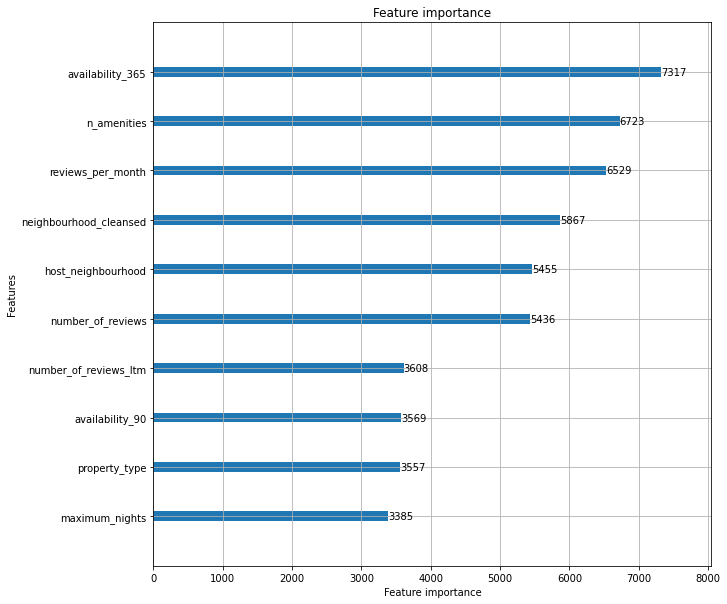

In [21]:
ax = lgb.plot_importance(gbm, max_num_features = 10, figsize=(10, 10))

## VII. optimizations (hyper-parameter tuning, more features)

In [ ]:
# # II. hyper-parameter tunning:
# ## 9. CV/ grid, random search (build in k-fold)
# from sklearn.ensemble import RandomForestRegressor
# from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
# from sklearn.metrics import make_scorer, accuracy_score

# reg = RandomForestRegressor()
# n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
# max_features = ['auto', 'sqrt']
# max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
# max_depth.append(None)
# min_samples_split = [2, 5, 10]
# min_samples_leaf = [1, 2, 4]
# bootstrap = [True, False]
# # random_grid = {'n_estimators': n_estimators,
# #                'max_features': max_features,
# #                'max_depth': max_depth,
# #                'min_samples_split': min_samples_split,
# #                'min_samples_leaf': min_samples_leaf,
# #                'bootstrap': bootstrap}

# random_grid = {'max_features': max_features,
#                'min_samples_leaf': min_samples_leaf}

# mse_scorer = make_scorer(mean_squared_error)

# grid_obj = GridSearchCV(reg, random_grid, scoring=mse_scorer)
# grid_obj = grid_obj.fit(X_train, y_train)
# final_reg = grid_obj.best_estimator_
# print(grid_obj.best_params_)
# final_reg.fit(X_train, y_train)


### VI.2 sentiment analysis

In [32]:
!wget --no-check-certificate -r 'https://docs.google.com/uc?export=download&id=1-NxMLkd5XhmjAPaIbwkmboYhsqz4B1Oh' -O reviews_sentiment.pkl

will be placed in the single file you specified.

--2021-02-02 14:11:03--  https://docs.google.com/uc?export=download&id=1-NxMLkd5XhmjAPaIbwkmboYhsqz4B1Oh
Resolving docs.google.com... 172.217.160.110
Connecting to docs.google.com|172.217.160.110|:443... connected.
HTTP request sent, awaiting response... 302 Moved Temporarily
Location: https://doc-0g-bk-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/tspao07kr6ce0oq9f6tnct8kk0e1m7uq/1612246200000/17613598960855703770/*/1-NxMLkd5XhmjAPaIbwkmboYhsqz4B1Oh?e=download [following]
--2021-02-02 14:11:05--  https://doc-0g-bk-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/tspao07kr6ce0oq9f6tnct8kk0e1m7uq/1612246200000/17613598960855703770/*/1-NxMLkd5XhmjAPaIbwkmboYhsqz4B1Oh?e=download
Resolving doc-0g-bk-docs.googleusercontent.com... 172.217.160.65
Connecting to doc-0g-bk-docs.googleusercontent.com|172.217.160.65|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspeci

In [22]:
with open("reviews_sentiment.pkl", 'rb') as f:
    reviews_with_sentiment = pickle.load(f)

In [23]:
reviews_with_sentiment

,listing_id,id,date,reviewer_id,reviewer_name,sentiment,positive_prob
0,29967,62788,2010-07-09,151260,Debbie,0.5,0.997993
1,29967,64568,2010-07-14,141552,Eric,0.5,0.997305
2,29967,67502,2010-07-22,141591,David,0.5,0.831154
3,29967,70466,2010-07-29,125982,Anders,0.5,0.995724
4,29967,74876,2010-08-07,29835,Miyoko,0.5,0.998525
...,...,...,...,...,...,...,...
443410,46995597,715777185,2020-12-15,44543376,Joshua,0.5,0.998463
443411,46995597,715948454,2020-12-16,346790349,Mike,0.5,0.998892
443412,46995597,716097352,2020-12-17,370055591,Hanna,0.5,0.998265
443413,46995597,716330508,2020-12-18,299951196,Trina,0.5,0.999041


- sentiment: -0.5(most negative) ~ 0.5(most positive)
- positive_prob: prediction from setimental fine-tuned bert model of probability of positive emotion 

In [37]:
df_agg_sentiment = reviews_with_sentiment.groupby(["listing_id"])["sentiment"].mean()
df_all_with_review = pd.merge(df_all, df_agg_sentiment, how='left', left_on='id', right_on='listing_id')
df_all_with_review.sentiment = df_all_with_review.sentiment.fillna(0)

In [38]:
X = df_all_with_review.drop(["id"],axis=1)
X_train, X_test, y_train_log, y_test_log = train_test_split(X, Y, test_size=0.33, random_state=9527)


# create dataset for lightgbm
lgb_train = lgb.Dataset(X_train, y_train_log)
lgb_eval = lgb.Dataset(X_test, y_test_log, reference=lgb_train)

# specify your configurations as a dict
params = {
    'boosting_type': 'gbdt',
    'objective': 'regression',
    'metric': {'l2', 'l1'},
    'num_leaves': 31,
    'learning_rate': 0.05,
    'feature_fraction': 0.9,
    'bagging_fraction': 0.8,
    'bagging_freq': 5,
    'verbose': 0
}

print('Starting training...')
gbm_sentiment = lgb.train(params,
                lgb_train,
                num_boost_round=3000,
                valid_sets=None)


# print('Saving model...')
# gbm_sentiment.save_model('model_sentiment.txt')
# print('Starting predicting...')
# y_pred = gbm_sentiment.predict(X_test, num_iteration=gbm.best_iteration)
# print('The rmse of prediction is:', mean_squared_error(y_test, y_pred) ** 0.5)

# ax = lgb.plot_importance(gbm_sentiment, max_num_features = 10)

Starting training...
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002704 seconds.
You can set `force_col_wise=true` to remove the overhead.


Saving model...
Starting predicting...
The rmse of prediction is: 180.4190423429854


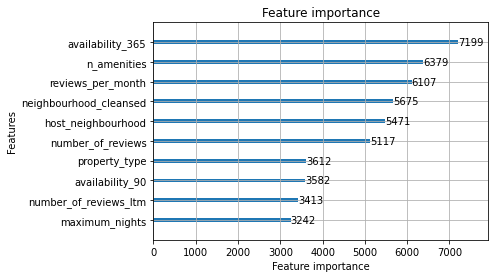

In [39]:
print('Saving model...')
gbm_sentiment.save_model('model_sentiment.txt')
print('Starting predicting...')
y_pred = np.expm1(gbm_sentiment.predict(X_test, num_iteration=gbm.best_iteration))
y_test = np.expm1(y_test_log) 
print('The rmse of prediction is:', mean_squared_error(y_test, y_pred) ** 0.5)

ax = lgb.plot_importance(gbm_sentiment, max_num_features = 10)



It's slightly improved after adding sentimental variable 

In [29]:
def plotCorrelationMatrix(df, graphWidth):
    df = df.dropna('columns') # drop columns with NaN
    df = df[[col for col in df if df[col].nunique() > 1]] # keep columns where there are more than 1 unique values
    if df.shape[1] < 2:
        print(f'No correlation plots shown: The number of non-NaN or constant columns ({df.shape[1]}) is less than 2')
        return
    corr = df.corr()
    plt.figure(num=None, figsize=(graphWidth, graphWidth), dpi=80, facecolor='w', edgecolor='k')
    corrMat = plt.matshow(corr, fignum = 1)
    plt.xticks(range(len(corr.columns)), corr.columns, rotation=90)
    plt.yticks(range(len(corr.columns)), corr.columns)
    plt.gca().xaxis.tick_bottom()
    plt.colorbar(corrMat)
    plt.title('Correlation Matrix for', fontsize=15)
    plt.show()


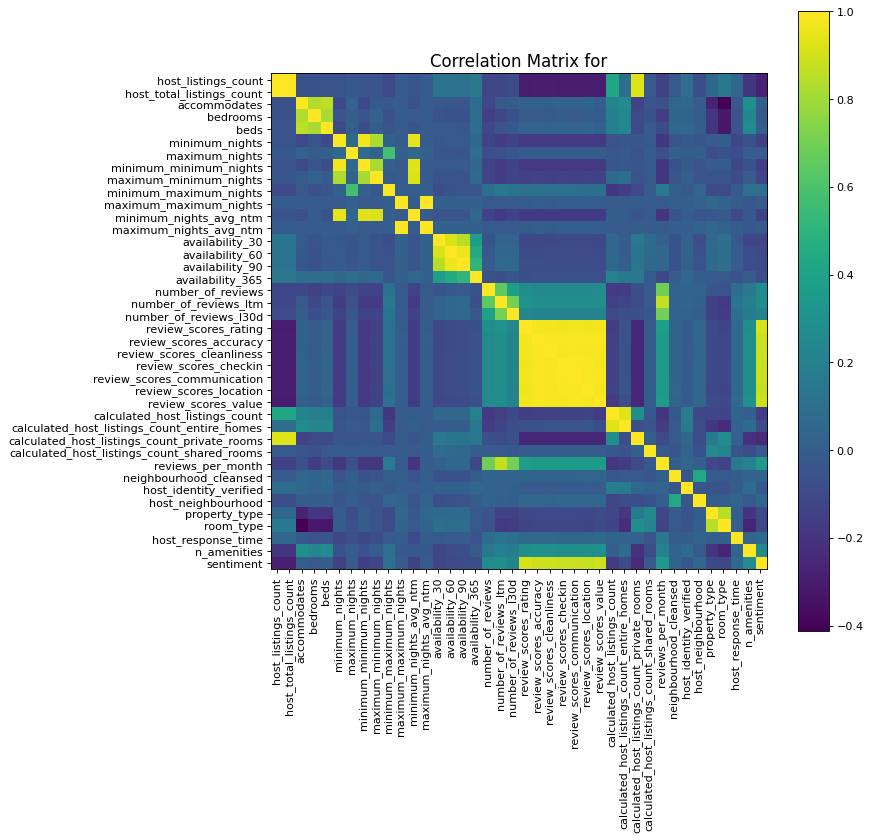

In [41]:
df_plot = df_all_with_review.drop(["id"],axis=1)
df_plot["Y"] = Y
plotCorrelationMatrix(df_plot, 10)